## Acute lymphoblastic leukemia 

Acute lymphoblastic leukemia (ALL) is the most common type of childhood cancer and accounts for approximately 25% of the pediatric cancers.

These cells have been segmented from microscopic images and are representative of images in the real-world because they contain some staining noise and illumination errors, although these errors have largely been fixed in the course of acquisition.

The task of identifying immature leukemic blasts from normal cells under the microscope is challenging due to morphological similarity and thus the ground truth labels were annotated by an expert oncologist.


[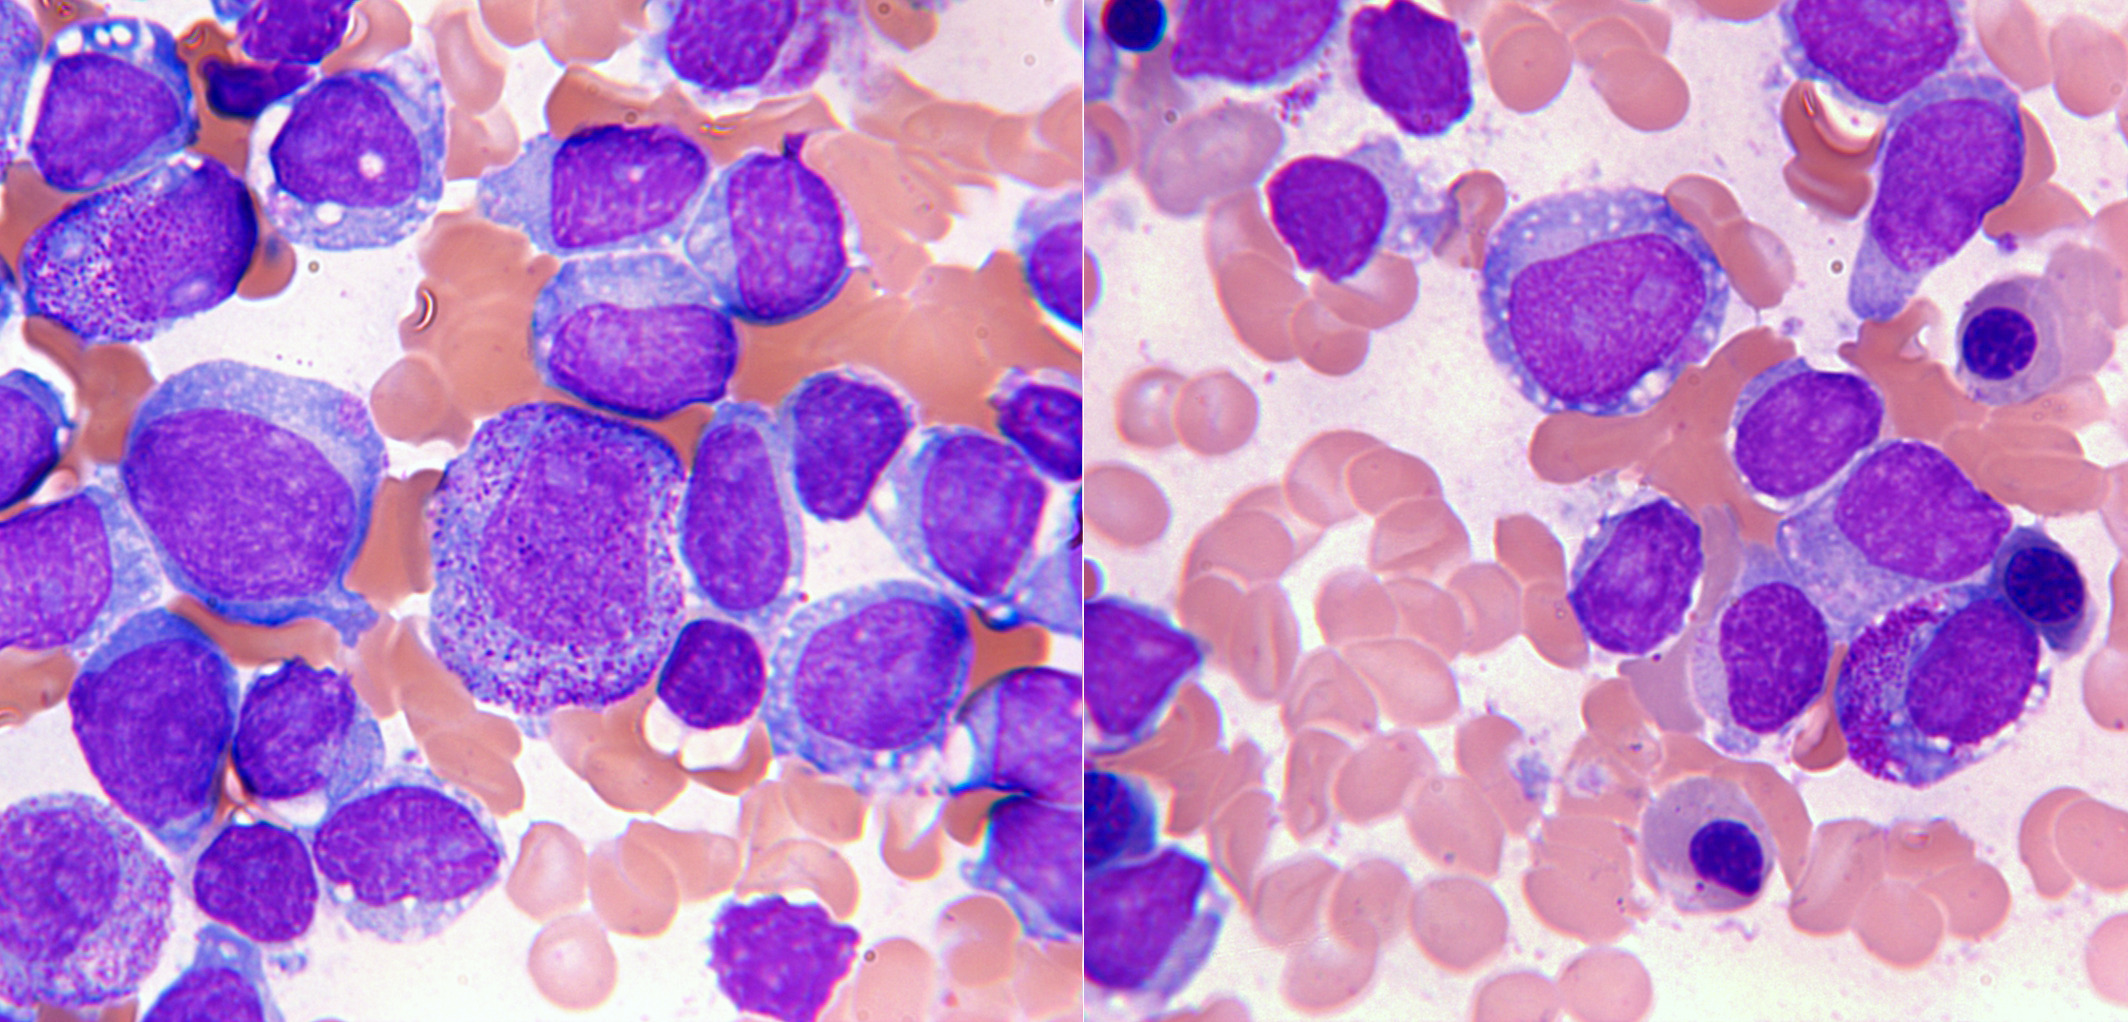](http://)

# *EfficientNet* 

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients.


[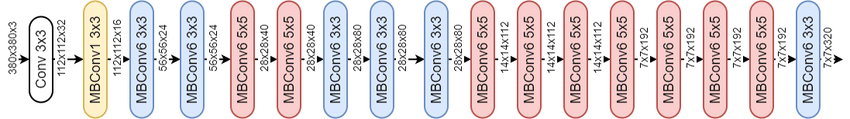](http://)


### Data Citation
Gupta, A., & Gupta, R. (2019). ALL Challenge dataset of ISBI 2019  

[The Cancer Imaging Archive.](https://doi.org/10.7937/tcia.2019.dc64i46r)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os.path
import tqdm
import glob
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.EfficientNetB7 import EfficientNetB7
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [2]:
from tensorflow.keras.applications.inception_v3 import  preprocess_input

In [3]:
df_train_0_all = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')

In [4]:
df_train_0_hem = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')

In [5]:
df_train_1_all = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
df_traint1_hem = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
df_train_2_all = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
df_train_2_hem = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

In [6]:

valdata=pd.read_csv('../input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [7]:
a, b, c= len(df_train_0_all ), len(df_train_1_all), len(df_train_2_all)
d = a + b + c
print("Total observation:", d)

Total observation: 7272


In [8]:
a, b, c = len(df_train_0_hem), len(df_traint1_hem), len(df_train_2_hem)
d = a + b + c
print("Total observation:", d)

Total observation: 3389


In [9]:
len(valdata)

1867

In [10]:
valdata

Patient_ID new_names  labels
0      UID_57_29_1_all.bmp     1.bmp       1
1      UID_57_22_2_all.bmp     2.bmp       1
2      UID_57_31_3_all.bmp     3.bmp       1
3     UID_H49_35_1_hem.bmp     4.bmp       0
4      UID_58_6_13_all.bmp     5.bmp       1
...                    ...       ...     ...
1862   UID_54_33_1_all.bmp  1863.bmp       1
1863   UID_55_24_1_all.bmp  1864.bmp       1
1864  UID_H32_20_1_hem.bmp  1865.bmp       0
1865   UID_54_30_2_all.bmp  1866.bmp       1
1866   UID_66_10_3_all.bmp  1867.bmp       1

[1867 rows x 3 columns]

In [11]:
valdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient_ID  1867 non-null   object
 1   new_names   1867 non-null   object
 2   labels      1867 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.9+ KB


In [12]:
valdata.describe()

labels
count  1867.000000
mean      0.652919
std       0.476169
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

In [14]:
A = []
H = []

A.extend(df_train_0_all)
A.extend(df_train_1_all)
A.extend(df_train_2_all)

H.extend(df_train_0_hem)
H.extend(df_traint1_hem)
H.extend(df_train_2_hem)

A = np.array(A)
H = np.array(H)

len(A), len(H)

(7272, 3389)

100%|██████████| 5/5 [00:00<00:00, 24.38it/s]


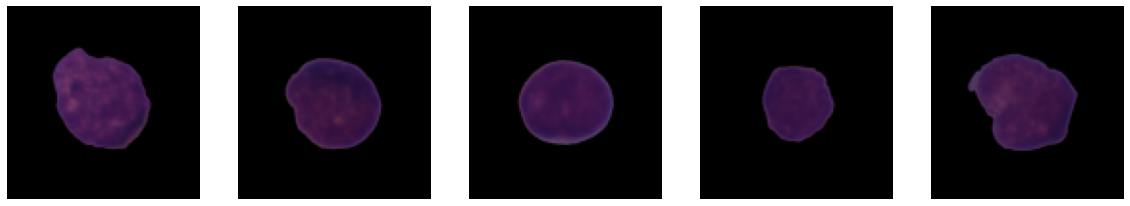

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(A))
    img  = imread(A[rand])
    img  = resize(img, (100,100))
    ax[i].imshow(img)
    ax[i].axis('off')

100%|██████████| 5/5 [00:00<00:00, 26.76it/s]


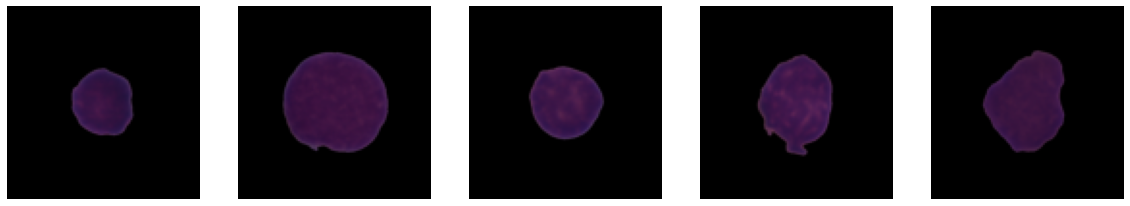

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(H))
    img  = imread(H[rand])
    img  = resize(img, (100,100))
    ax[i].imshow(img)
    ax[i].axis('off')

In [17]:
Image = []
Label = []

for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (100,100))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (100,100))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

100%|██████████| 3389/3389 [01:55<00:00, 29.23it/s]


((10661, 100, 100, 3), (10661,))

In [18]:
del A
del H

In [19]:
# Shuffle the data as results are appened.

Image, Label = shuffle(Image, Label, random_state = 41)

100%|██████████| 5/5 [00:00<00:00, 569.60it/s]


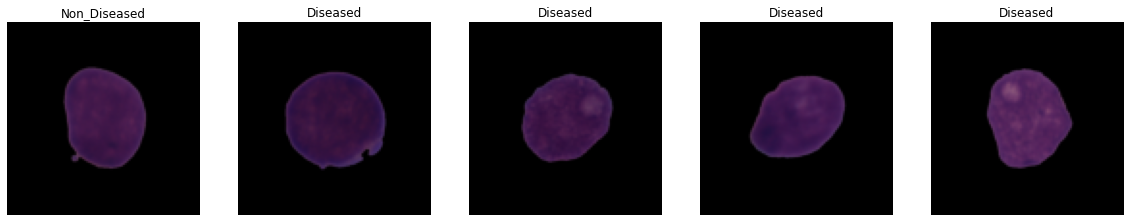

In [20]:
# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [21]:
# Assigning Images and Label to new variable 

X = Image
y = Label

In [22]:
del Image 
del Label

In [23]:
# Checking target coloumn distribution

valdata.labels.value_counts()

1    1219
0     648
Name: labels, dtype: int64

In [24]:
# Loading image and storing it numpy array.

X_val = []

for image_name in valdata.new_names:
    # Loading images
    img = imread('../input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing 
    img = resize(img, (100,100))
    # Appending them into list
    X_val.append(img)
 
# Converting into array
X_val = np.array(X_val)


# Storing target values as well 
y_val = valdata.labels.values

In [25]:
# Augmentation & Applying preprocessing function of pre-trained model.

train_datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    shear_range=0.2,
                                    zoom_range = 0.2,
                                    preprocessing_function=preprocess_input)
train_datagen.fit(X)

In [26]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen.fit(X_val)

In [27]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(100,100,3),include_top=False,weights="imagenet")

258080768/258076736 [==============================] - 3s 0us/step


In [28]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [29]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))

In [30]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 4, 4, 2560)        64097687  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2560)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40960)             163840    
_________________________________________________________________
dense (Dense)                (None, 32)                1310752   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

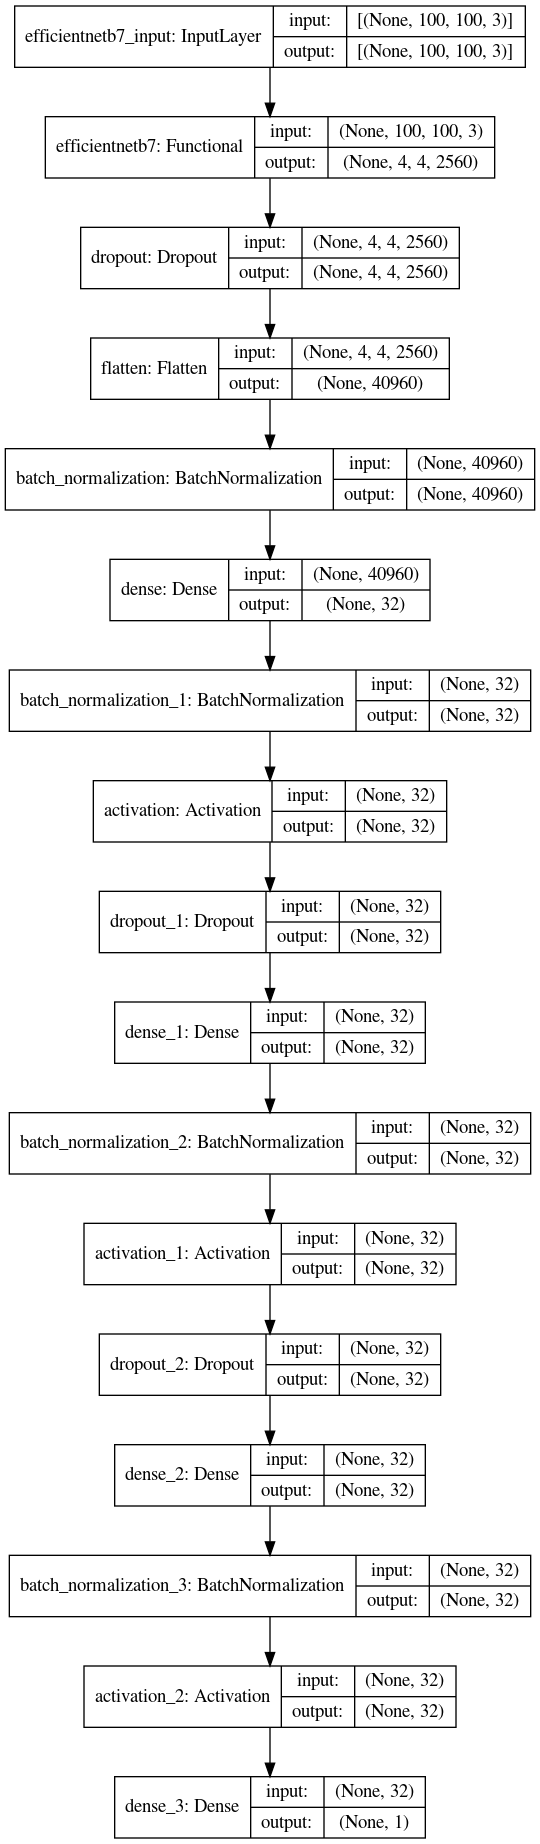

In [31]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [32]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [34]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=5)

In [35]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [37]:
%time
history=model.fit(train_datagen.flow(X, y, batch_size=512),validation_data = (X_val, y_val),epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10 µs
Epoch 1/100
21/21 [==============================] - 1123s 54s/step - loss: 0.8044 - accuracy: 0.4011 - precision: 0.6765 - recall: 0.2338 - auc: 0.4966 - f1_score: 0.3432 - val_loss: 2.2659 - val_accuracy: 0.6529 - val_precision: 0.6529 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.7875
Epoch 2/100
21/21 [==============================] - 1095s 52s/step - loss: 0.7141 - accuracy: 0.5161 - precision: 0.6883 - recall: 0.5311 - auc: 0.5088 - f1_score: 0.5933 - val_loss: 1.1352 - val_accuracy: 0.6529 - val_precision: 0.6529 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_score: 0.7875
Epoch 3/100
21/21 [==============================] - 1077s 51s/step - loss: 0.6783 - accuracy: 0.6111 - precision: 0.6838 - recall: 0.7995 - auc: 0.5053 - f1_score: 0.7355 - val_loss: 1.0717 - val_accuracy: 0.6529 - val_precision: 0.6529 - val_recall: 1.0000 - val_auc: 0.3788 - val_f1_score: 0.7875
Epoch 4/100
21/21 [===============

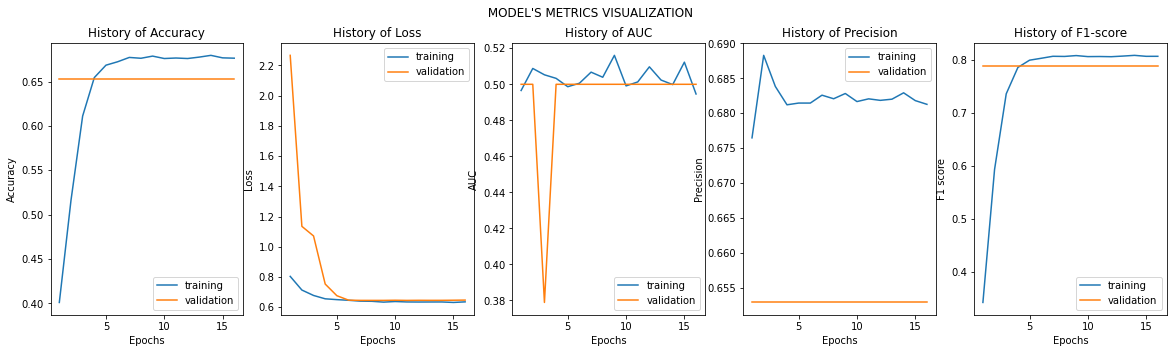

In [42]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score'])